In [1]:
import sys
import os
import predify
import pandas as pd

from torchvision.models import alexnet,vgg16,resnet18

import torch
from torch.autograd import Variable as V
import torchvision
from PIL import Image
import numpy as np
import os
import re
import shutil
import matplotlib.pyplot as plt

import pathlib
import torchvision.transforms as T
import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--path', default='Tutorial_LE_Results_Ridge_opt/', type=str)
parser.add_argument('--arch', default='vgg16', type=str)
parser.add_argument('--subject', default=7, type=int)
parser.add_argument('--n', default=3, type=int)

args = parser.parse_args('')

In [3]:
import pandas as pd

def open_results(file_path, roi_category=None):
    """
    Loads a DataFrame from a CSV file and optionally filters it by an ROI category.

    Args:
    - file_path (str): The path to the CSV file.
    - roi_category (str, optional): The category key from roi_mappings to filter by.

    Returns:
    - pd.DataFrame: The loaded (and optionally filtered) DataFrame.
    """
    # Load the DataFrame from the CSV file
    dataframe = pd.read_csv(file_path)
    
    # If an ROI category is specified, filter the DataFrame
    if roi_category:
        # Define ROI mappings
        '''
        roi_mappings = {
            'prf-visualrois': ['V1', 'V2', 'V3', 'hV4'], 
            'floc-bodies': ['EBA', 'FBA-1', 'FBA-2', 'mTL-bodies'],
            'floc-faces': ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces'],
            'floc-places': ['OPA', 'PPA', 'RSC'],
            'floc-words': ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words'],
            #'streams': ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
        }'''

        roi_mappings = {
            'prf-visualrois': ['V1', 'V2', 'V3', 'hV4'], 
            'floc-bodies': ['EBA', 'FBA-2'],
            'floc-faces': ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces'],
            'floc-places': ['OPA', 'PPA', 'RSC'],
            'floc-words': ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words'],
        }
        
        # Check if the specified category exists in roi_mappings
        if roi_category not in roi_mappings:
            raise ValueError(f"Category '{roi_category}' not found in roi_mappings.")
        
        # Filter the DataFrame
        dataframe = dataframe.loc[dataframe['ROI'].str.split('_').str[0].isin(roi_mappings[roi_category])]
    
    return dataframe

In [4]:
import numpy as np
def get_dataframe(sp_nonpredify,sp_predify,roi_category):
    results_df_nonpredify = open_results(sp_nonpredify, roi_category)
    results_df_predify= open_results(sp_predify, roi_category)
    #results_df_bert = open_results(f"Tutorial_LE_Results_Ridge_opt/subj{subject}" + "/PVGG16-FTS-custom.csv", roi_category)
    default = np.array(results_df_predify['R'].tolist())
    default_df = results_df_predify
    #custom = np.array(results_df_bert['R'].tolist())
    baseline = np.array(results_df_nonpredify['R'].tolist())
    baseline_df = results_df_nonpredify
    rd = default/baseline
    #rc = custom/baseline
    return rd,default,baseline

In [5]:
def get_sp_predify(arch,subj_idx,n,key):
    
    fts_name = arch
    
    if arch =='alexnet':
        save_path_predify = os.path.join(args.path,'subj' + str(subj_idx),'ts'+ str(n),'PALEXNET-FTS-default.csv')
        #save_path_predify = os.path.join(f"Tutorial_subj{subject}_increase_fbm/{fts_name}_{key}/ts" + str(args.n),'PALEXNET-FTS-default.csv')

    elif arch == 'vgg16':
        save_path_predify = os.path.join(args.path,'subj' + str(subj_idx),'ts'+ str(n),'vgg16.csv')
        #save_path_predify = os.path.join(f"Tutorial_subj{subj_idx}_increase_fbm/{fts_name}_{key}/ts" + str(args.n),'PVGG16-FTS-default.csv')
        
    
    sp_predify=f"Tutorial_LE_Results_Ridge_opt/subj{subj_idx}/vgg16_{key}/ts" + str(n) +  '/' +save_path_predify.split('/')[-1] 
    
    sp_nonpredify = f"../Tutorial_LE_Results_Ridge_opt/subj{subj_idx}/" + args.arch + '_nonpredify.csv'
    #sp_nonpredify = f"Tutorial_LE_Results_Ridge_opt/subj{subj_idx}/vgg16_zero/ts" + str(n) +  '/' +save_path_predify.split('/')[-1] 
    return sp_predify,sp_nonpredify

In [6]:
def Avg_R_sub(arch,subject,n,key,ROI_Cat):
    R_pred = {}
    R_nonpred = {}
    R_rd= {}
    for roi_category in ROI_Cat:
        
        R_pred[roi_category] = []
        R_nonpred[roi_category] = []
        R_rd[roi_category] = []
        
        for sub in subject:
            sp_predify,sp_nonpredify = get_sp_predify(arch,sub,n,key)
            rd,default,baseline = get_dataframe(sp_nonpredify,sp_predify,roi_category)
            
            R_pred[roi_category].append(default)
            R_nonpred[roi_category].append(baseline)
            R_rd[roi_category].append(rd)
            
    return R_pred,R_nonpred,R_rd

In [7]:
def creat_df(r_avg,ROI_Cat,k):
    if args.arch == 'vgg16':
        sp_predify = '../Tutorial_LE_Results_Ridge_opt/subj7/PVGG16-FTS-default.csv'
    else:
        sp_predify = '../Tutorial_LE_Results_Ridge_opt/subj7/PALEXNET-FTS-default.csv'
        
    roi_category = ROI_Cat[k]
    results_df_predify= open_results(sp_predify, roi_category)
    data = {
    'ROI': results_df_predify['ROI'].tolist(),
    'Layer': results_df_predify['Layer'].tolist(),
    'Model': results_df_predify['Model'].tolist(),
    'SEM':results_df_predify['SEM'].tolist(),
    'Significance':results_df_predify['Significance'].tolist(),
    'LNC':results_df_predify['LNC'].tolist(),
    'UNC':results_df_predify['UNC'].tolist(),
    'R_default':r_avg}
    df = pd.DataFrame(data)
    return df

In [8]:
def final_analysis(subject,key,ROI_Cat,k):
    M_rd = []
    M_pred = []
    M_nonpred = []

    ST_rd = []
    ST_pred = []
    ST_nonpred = []

    Md_rd = []
    Md_pred = []
    Md_nonpred = []

    for n in range(1,11):
        print(n)
        R_pred,R_nonpred,R_rd = Avg_R_sub(args.arch,subject,n,key,ROI_Cat)
    
        Avg_R_pred = np.array(R_pred[ROI_Cat[k]]).mean(0)
        Avg_R_nonpred = np.array(R_nonpred[ROI_Cat[k]]).mean(0)
        Avg_R_rd = np.array(R_rd[ROI_Cat[k]]).mean(0)

        std_R_pred = np.array(R_pred[ROI_Cat[k]]).std(0)/np.sqrt(len(subject))
        std_R_nonpred = np.array(R_nonpred[ROI_Cat[k]]).std(0)/np.sqrt(len(subject))
        std_R_rd = np.array(R_rd[ROI_Cat[k]]).std(0)/np.sqrt(len(subject))
    
        df_rd =creat_df(Avg_R_rd,ROI_Cat,k)
        df_pred =creat_df(Avg_R_pred,ROI_Cat,k)
        df_nonpred =creat_df(Avg_R_nonpred,ROI_Cat,k)

        df_rd_std =creat_df(std_R_rd,ROI_Cat,k)
        df_pred_std =creat_df(std_R_pred,ROI_Cat,k)
        df_nonpred_std =creat_df(std_R_nonpred,ROI_Cat,k)

        grouped_pred = df_pred.groupby('Layer').agg(
        mean_accuracy=('R_default', 'mean'),
        median_accuracy=('R_default', 'median'),
        std_accuracy=('R_default', 'std')).reset_index()

        grouped_nonpred = df_nonpred.groupby('Layer').agg(
        mean_accuracy=('R_default', 'mean'),
        median_accuracy=('R_default', 'median'),
        std_accuracy=('R_default', 'std')).reset_index()

        grouped_rd = df_rd.groupby('Layer').agg(
        mean_accuracy=('R_default', 'mean'),
        median_accuracy=('R_default', 'median'),
        std_accuracy=('R_default', 'std')).reset_index()
    
        me_rd = grouped_rd['mean_accuracy'].tolist()
        me_pred = grouped_pred['mean_accuracy'].tolist()
        me_nonpred = grouped_nonpred['mean_accuracy'].tolist()

        med_rd = grouped_rd['median_accuracy'].tolist()
        med_pred = grouped_pred['median_accuracy'].tolist()
        med_nonpred = grouped_nonpred['median_accuracy'].tolist()

        st_rd_roi = np.array(grouped_rd['std_accuracy'].tolist())/np.sqrt(df_nonpred['Layer'].nunique())
        st_pred_roi = np.array(grouped_pred['std_accuracy'].tolist())/np.sqrt(df_nonpred['Layer'].nunique())
        st_nonpred_roi = np.array(grouped_nonpred['std_accuracy'].tolist())/np.sqrt(df_nonpred['Layer'].nunique())
        
        st_rd = np.sqrt(std_R_rd.mean()**2 + st_rd_roi**2)
        st_pred = np.sqrt(std_R_pred.mean()**2 + st_pred_roi**2)
        st_nonpred = np.sqrt(std_R_nonpred.mean()**2 + st_nonpred_roi**2)
    
        M_rd.append(me_rd)
        M_pred.append(me_pred)
        M_nonpred.append(me_nonpred)

        ST_rd.append(st_rd)
        ST_pred.append(st_pred)
        ST_nonpred.append(st_nonpred)

        Md_rd.append(med_rd)
        Md_pred.append(med_pred)
        Md_nonpred.append(med_nonpred)

    return M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred

In [9]:
#n=1, time step 10. So reverse to start from time step 1
def reverse_value(M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred):
    MM_rd = np.array(M_rd)
    MM_pred = np.array(M_pred)
    MM_nonpred = np.array(M_nonpred)

    SS_rd = np.array(ST_rd)
    SS_pred = np.array(ST_pred)
    SS_nonpred = np.array(ST_nonpred)

    MMd_rd = np.array(Md_rd)
    MMd_pred = np.array(Md_pred)
    MMd_nonpred = np.array(Md_nonpred)
    MMd_rd = MMd_pred/MMd_nonpred

    MM_reversed_rd = MM_rd[::-1]
    MM_reversed_pred = MM_pred[::-1]
    MM_reversed_nonpred = MM_nonpred[::-1]

    SS_reversed_rd = SS_rd[::-1]/4
    SS_reversed_pred = SS_pred[::-1]
    SS_reversed_nonpred = SS_nonpred[::-1]

    MMd_reversed_rd = MMd_rd[::-1]
    MMd_reversed_pred = MMd_pred[::-1]
    MMd_reversed_nonpred = MMd_nonpred[::-1]
    return MM_reversed_rd,MM_reversed_pred,MM_reversed_nonpred,SS_reversed_rd,SS_reversed_pred,SS_reversed_nonpred

In [10]:
from scipy.stats import t as TStat
from scipy.stats import t

def significance_difference(MM_reversed_rd,SS_reversed_rd):
    
    N = MM_reversed_rd.shape[0]  # Number of repetitions (samples)
    df = N - 1  # Degrees of freedom
    P_alltimesteps = np.zeros(MM_reversed_rd.shape)
    time_steps = np.arange(1, 11)

    # Loop through each line
    for i in range(MM_reversed_rd.shape[1]):
        print(f"Significance results for PCoder {i+1}:")
    
        # Loop through each time step
        for t_idx, time in enumerate(time_steps):
            mean_t = MM_reversed_rd[t_idx, i]  # Mean at time step t for line i
            se_t = SS_reversed_rd[t_idx, i]    # Standard error at time step t for line i
        
            # Calculate t-statistic
            t_stat = (mean_t - 1.0) / se_t
        
            # Calculate p-value
            p_value = 2 * (1.0 - TStat.cdf(abs(t_stat), df))  # Two-tailed test
            #p_value = 2 * t.sf(abs(t_stat), df)  # Two-tailed test

            P_alltimesteps[t_idx,i] = p_value
        
            # Report results
            print(f"Time {time:.2f}: t-stat = {t_stat:.2f}, p-value = {p_value:.4f}")
        
            if p_value < 0.05:
                print(f"  Significant at p < 0.05")
            else:
                print(f"  Not significant at p < 0.05")
    return P_alltimesteps

In [36]:
arch = args.arch
subject = [1,2,4,5,7]
#subject = [1,2,7]
k = 0 #rois
ROI_Cat = ['prf-visualrois','floc-bodies','floc-faces','floc-places','floc-words']
key = 'zero'

In [37]:
M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred = final_analysis(subject,key,ROI_Cat,k)

1
2
3
4
5
6
7
8
9
10


In [38]:
MM_reversed_rd,MM_reversed_pred,MM_reversed_nonpred,SS_reversed_rd,SS_reversed_pred,SS_reversed_nonpred=reverse_value(M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred)

In [39]:
P_alltimesteps = significance_difference(MM_reversed_rd,SS_reversed_rd)

Significance results for PCoder 1:
Time 1.00: t-stat = -22.37, p-value = 0.0000
  Significant at p < 0.05
Time 2.00: t-stat = -30.29, p-value = 0.0000
  Significant at p < 0.05
Time 3.00: t-stat = -20.80, p-value = 0.0000
  Significant at p < 0.05
Time 4.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 5.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 6.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 7.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 8.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 9.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 10.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Significance results for PCoder 2:
Time 1.00: t-stat = -8.11, p-value = 0.0000
  Significant at p < 0.05
Time 2.00: t-stat = -11.75, p-value = 0.0000
  Significant at p < 0.05
Time 3.00: t-stat = -7.39, p-value = 0.0000
  Significant at p < 0.05
Time 4.0

<Figure size 800x200 with 0 Axes>

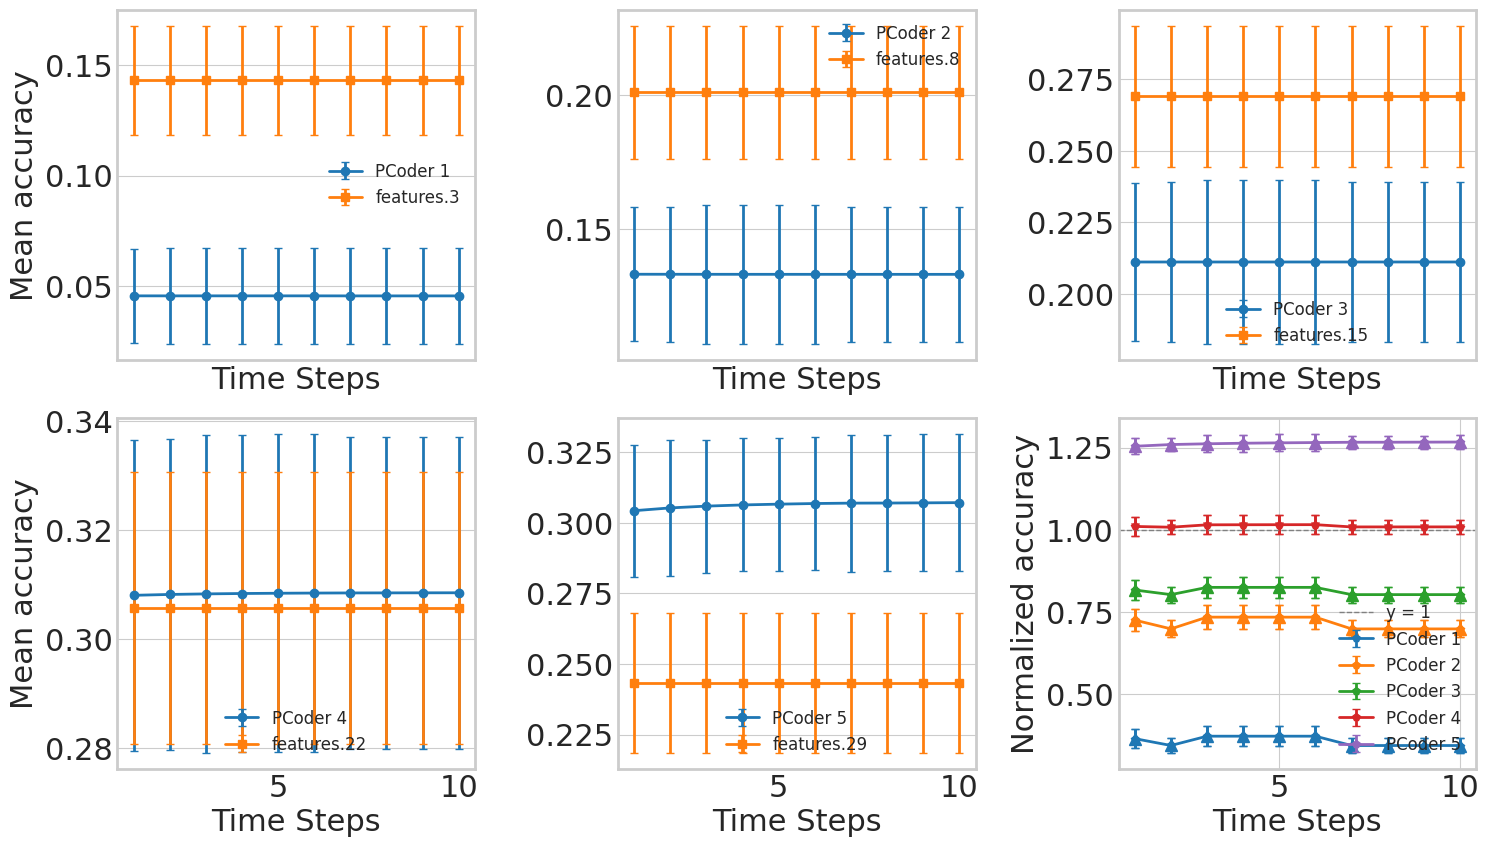

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.colors as mcolors
import matplotlib as mpl
from scipy import stats


random.seed(5)
fig = plt.figure()
fig.set_size_inches((8,2))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 22 
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 12

# Define the time steps
time_steps = np.arange(1, 11)

# Set up the subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 9), sharex=True)

# Assuming MM_reversed_pred and SS_reversed_pred have the same shape
num_pcoders = MM_reversed_pred.shape[1]

features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the 3x2 array of axes for easy iteration
axs = axs.flatten()

# List to keep track of the actual positions to plot
plot_positions = [0, 1, 2, 3, 4]  # Skipping position 4

for i, pos in enumerate(plot_positions):
    # Plot the pred line with error bars
    axs[pos].errorbar(time_steps, MM_reversed_pred[:, i], yerr=SS_reversed_pred[:, i], fmt='-o', label=f'PCoder {i+1}', capsize=3)
    
    # Plot the nonpred line with error bars
    axs[pos].errorbar(time_steps, MM_reversed_nonpred[:, i], yerr=SS_reversed_nonpred[:, i], fmt='-s', label=features_map[i], capsize=3)
    
    axs[pos].legend()
    
    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)
    axs[pos].set_xlabel('Time Steps')
    #axs[pos].axhline(y=1, color='r', linestyle='--', linewidth=1, label='y = 1')
    '''
    for t in range(len(time_steps)):
        if P_alltimesteps[t][i] < 0.05:
            axs[pos].annotate('*', (time_steps[t], max(MM_reversed_pred[t, i], MM_reversed_nonpred[t, i])), 
                              color='red', fontsize=14)
    '''
for i in range(MM_reversed_rd.shape[1]):
    axs[5].errorbar(time_steps, MM_reversed_rd[:, i], yerr=SS_reversed_rd[:, i], label=f'PCoder {i+1}', linestyle='-', marker='p',capsize=3)
    # Overlay points with distinct markers for significant and non-significant points
    for t in range(len(time_steps)):
        if P_alltimesteps[t][i] < 0.05:
            marker = '^'  # Triangle marker for significant points
            marker_color = f'C{i}'  # Use red for significant points
            marker_size = 8  # Increase size for emphasis
        else:
            marker = '1'  # Circle marker for non-significant points
            marker_color = f'C{i}'  # Use line color for non-significant points
            marker_size = 8  # Default size
            
        axs[5].errorbar(
            time_steps[t],  # Single time step
            MM_reversed_rd[t, i],  # Corresponding y-value
            yerr=SS_reversed_rd[t, i],  # Corresponding error
            fmt=marker,  # Conditionally selected marker
            capsize=3,
            color=marker_color,  # Use marker-specific color
            markersize=marker_size  # Set marker size
        )
axs[5].axhline(y=1, color='grey', linestyle='--', linewidth=1, label='y = 1')

# Add labels and title
axs[5].set_xlabel('Time Steps')
axs[5].set_ylabel('Normalized accuracy')
#axs[5].title('Normalized averaged encoding accuracy across time steps (VGG16)')

# Add legend
axs[5].legend()
axs[5].legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=1)

# Add common x-axis label and title
axs[3].set_ylabel('Mean accuracy')
axs[0].set_ylabel('Mean accuracy')
#axs[0].suptitle('Encoding accuracy (VWFA-1) over timestep')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Adjust layout for the legends
fig.subplots_adjust(bottom=0.1)  # Adjust bottom margin for legends
fig.subplots_adjust(wspace=0.4)

# Remove the subplot at the second row, second column (index 4)
#fig.delaxes(axs[4])

#filename = 'roi_' + str(k) +'_fbm_key_' + key + '.png'
#plt.savefig(filename, dpi=300)

filename = filename = 'roi_' + str(k) +'_fbm_key_' + key + '.pdf'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

In [11]:
def get_IT_Rd(subject,key,ROI_Cat):
    
    R = []
    R_pred = []
    R_nonpred = []
    #P = []

    for k in range(1,5): #rois
        M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred = final_analysis(subject,key,ROI_Cat,k)
        MM_reversed_rd,MM_reversed_pred,MM_reversed_nonpred,SS_reversed_rd,SS_reversed_pred,SS_reversed_nonpred=reverse_value(M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred)
        #P_alltimesteps = significance_difference(MM_reversed_rd)
        
        R.append(MM_reversed_rd)
        R_pred.append(MM_reversed_pred)
        R_nonpred.append(MM_reversed_nonpred)
        #P.append(P_alltimesteps)

    Avg_R_rd = np.asarray(R).mean(0)
    std_R_rd = np.asarray(R).std(0)/np.sqrt(4)

    Avg_R_pred = np.asarray(R_pred).mean(0)
    std_R_pred = np.asarray(R_pred).std(0)/np.sqrt(4)

    Avg_R_nonpred = np.asarray(R_nonpred).mean(0)
    std_R_nonpred = np.asarray(R_nonpred).std(0)/np.sqrt(4)

    P_alltimesteps = significance_difference(Avg_R_rd,std_R_rd)
    #Avg_P = np.asarray(P).mean(0)
    #Avg_P = np.median(np.asarray(P))
    
    return Avg_R_rd,std_R_rd,Avg_R_pred,std_R_pred,Avg_R_nonpred,std_R_nonpred,P_alltimesteps

In [12]:
arch = args.arch
subject = [1,2,4,5,7]
ROI_Cat = ['prf-visualrois','floc-bodies','floc-faces','floc-places','floc-words']
#key = 'zero'
keys = ['zero','one','two','three','four','five']
Avg_R_rd_all = {}
std_R_rd_all = {}

Avg_R_nonpred_all = {}
std_R_nonpred_all = {}

Avg_R_pred_all = {}
std_R_pred_all = {}

Avg_P_all = {}

for key in keys:
    
    Avg_R_rd,std_R_rd,Avg_R_pred,std_R_pred,Avg_R_nonpred,std_R_nonpred,Avg_P = get_IT_Rd(subject,key,ROI_Cat)
    
    Avg_R_rd_all[key] = Avg_R_rd
    std_R_rd_all[key] = std_R_rd

    Avg_R_pred_all[key] = Avg_R_pred
    std_R_pred_all[key] = std_R_pred

    Avg_R_nonpred_all[key] = Avg_R_nonpred
    std_R_nonpred_all[key] = std_R_nonpred

    Avg_P_all[key] = Avg_P

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
Significance results for PCoder 1:
Time 1.00: t-stat = -11.27, p-value = 0.0000
  Significant at p < 0.05
Time 2.00: t-stat = -13.70, p-value = 0.0000
  Significant at p < 0.05
Time 3.00: t-stat = -9.68, p-value = 0.0000
  Significant at p < 0.05
Time 4.00: t-stat = -9.69, p-value = 0.0000
  Significant at p < 0.05
Time 5.00: t-stat = -9.68, p-value = 0.0000
  Significant at p < 0.05
Time 6.00: t-stat = -9.68, p-value = 0.0000
  Significant at p < 0.05
Time 7.00: t-stat = -13.68, p-value = 0.0000
  Significant at p < 0.05
Time 8.00: t-stat = -13.68, p-value = 0.0000
  Significant at p < 0.05
Time 9.00: t-stat = -13.68, p-value = 0.0000
  Significant at p < 0.05
Time 10.00: t-stat = -13.68, p-value = 0.0000
  Significant at p < 0.05
Significance results for PCoder 2:
Time 1.00: t-stat = -3.26, p-value = 0.0099
  Significant at p < 0.05
Time 2.00: t-stat = -3.71, p-value = 0.0049
  Significant at p < 0.05

<Figure size 800x200 with 0 Axes>

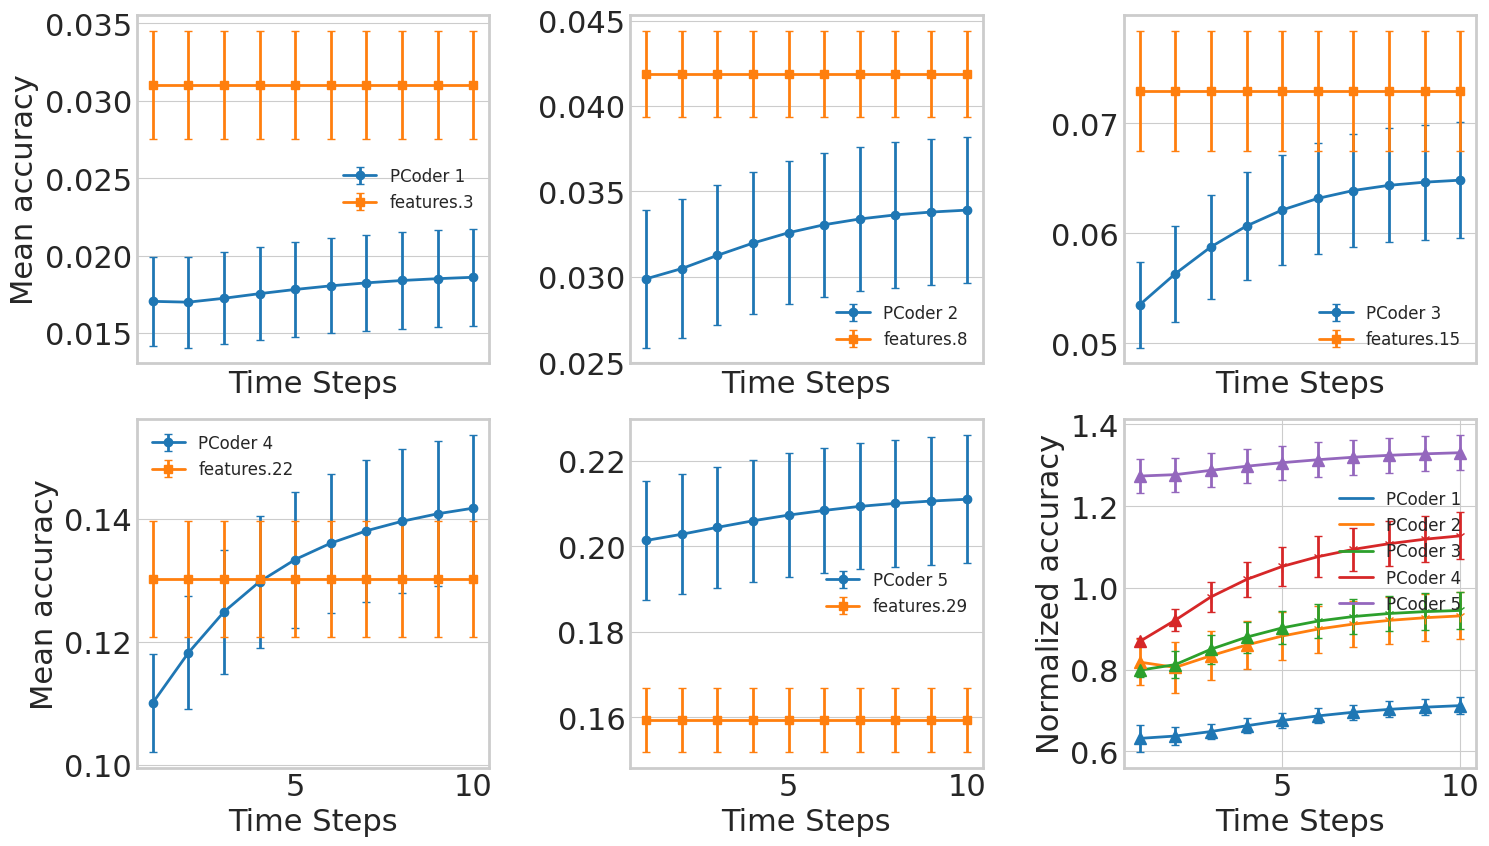

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.colors as mcolors
import matplotlib as mpl
from scipy import stats


random.seed(5)
fig = plt.figure()
fig.set_size_inches((8,2))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 22 
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 12

# Define the time steps
time_steps = np.arange(1, 11)

key = 'two'

# Set up the subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 9), sharex=True)

# Assuming MM_reversed_pred and SS_reversed_pred have the same shape
num_pcoders = Avg_R_pred_all[key].shape[1]

features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the 3x2 array of axes for easy iteration
axs = axs.flatten()

# List to keep track of the actual positions to plot
plot_positions = [0, 1, 2, 3, 4]  # Skipping position 4

for i, pos in enumerate(plot_positions):
    # Plot the pred line with error bars
    axs[pos].errorbar(time_steps, Avg_R_pred_all[key][:, i], yerr=std_R_pred_all[key][:, i], fmt='-o', label=f'PCoder {i+1}', capsize=3)
    
    # Plot the nonpred line with error bars
    axs[pos].errorbar(time_steps, Avg_R_nonpred_all[key][:, i], yerr=std_R_nonpred_all[key][:, i], fmt='-s', label=features_map[i], capsize=3)
    
    #axs[pos].set_ylabel('Pearson correlation coefficients averaged across subjects')
    axs[pos].legend()
    
    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)
    axs[pos].set_xlabel('Time Steps')
    #axs[pos].axhline(y=1, color='r', linestyle='--', linewidth=1, label='y = 1')

'''
for i in range(Avg_R_rd_all[key].shape[1]):
    axs[5].errorbar(time_steps, Avg_R_rd_all[key][:, i], yerr=std_R_rd_all[key][:, i], label=f'PCoder {i+1}', linestyle='-', marker='p',capsize=3)
    for t in range(len(time_steps)):
        if Avg_P_all[key][t][i] < 0.05:
            axs[5].annotate('*', (time_steps[t], max(Avg_R_pred_all[key][t, i], Avg_R_nonpred_all[key][t, i])), 
                              color='red', fontsize=22)
axs[5].axhline(y=1, color='grey', linestyle='--', linewidth=2, label='y = 1') '''

for i in range(Avg_R_rd_all[key].shape[1]):
    # Plot the line connecting all points
    axs[5].plot(
        time_steps,
        Avg_R_rd_all[key][:, i],
        linestyle='-', 
        label=f'PCoder {i+1}', 
        color=f'C{i}'  # Use consistent color
    )
    
    # Overlay points with distinct markers for significant and non-significant points
    for t in range(len(time_steps)):
        if Avg_P_all[key][t][i] < 0.05:
            marker = '^'  # Triangle marker for significant points
            marker_color = f'C{i}'  # Use red for significant points
            marker_size = 8  # Increase size for emphasis
        else:
            marker = '1'  # Circle marker for non-significant points
            marker_color = f'C{i}'  # Use line color for non-significant points
            marker_size = 8  # Default size
            
        axs[5].errorbar(
            time_steps[t],  # Single time step
            Avg_R_rd_all[key][t, i],  # Corresponding y-value
            yerr=std_R_rd_all[key][t, i],  # Corresponding error
            fmt=marker,  # Conditionally selected marker
            capsize=3,
            color=marker_color,  # Use marker-specific color
            markersize=marker_size  # Set marker size
        )


# Add labels and title
axs[5].set_xlabel('Time Steps')
axs[5].set_ylabel('Normalized accuracy')
#axs[5].title('Normalized averaged encoding accuracy across time steps (VGG16)')

# Add legend
axs[5].legend()
axs[5].legend(loc='lower right', bbox_to_anchor=(1.0, 0.4), ncol=1)

# Add common x-axis label and title
axs[3].set_ylabel('Mean accuracy')
axs[0].set_ylabel('Mean accuracy')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Adjust layout for the legends
fig.subplots_adjust(bottom=0.1)  # Adjust bottom margin for legends
fig.subplots_adjust(wspace=0.4)

# Remove the subplot at the second row, second column (index 4)
#fig.delaxes(axs[4])

#filename = 'roi_' + str(k) +'_fbm_key_' + key + '.png'
#plt.savefig(filename, dpi=300)

filename = filename = 'roi_it_fbm_key_' + key + '.pdf'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

<Figure size 800x600 with 0 Axes>

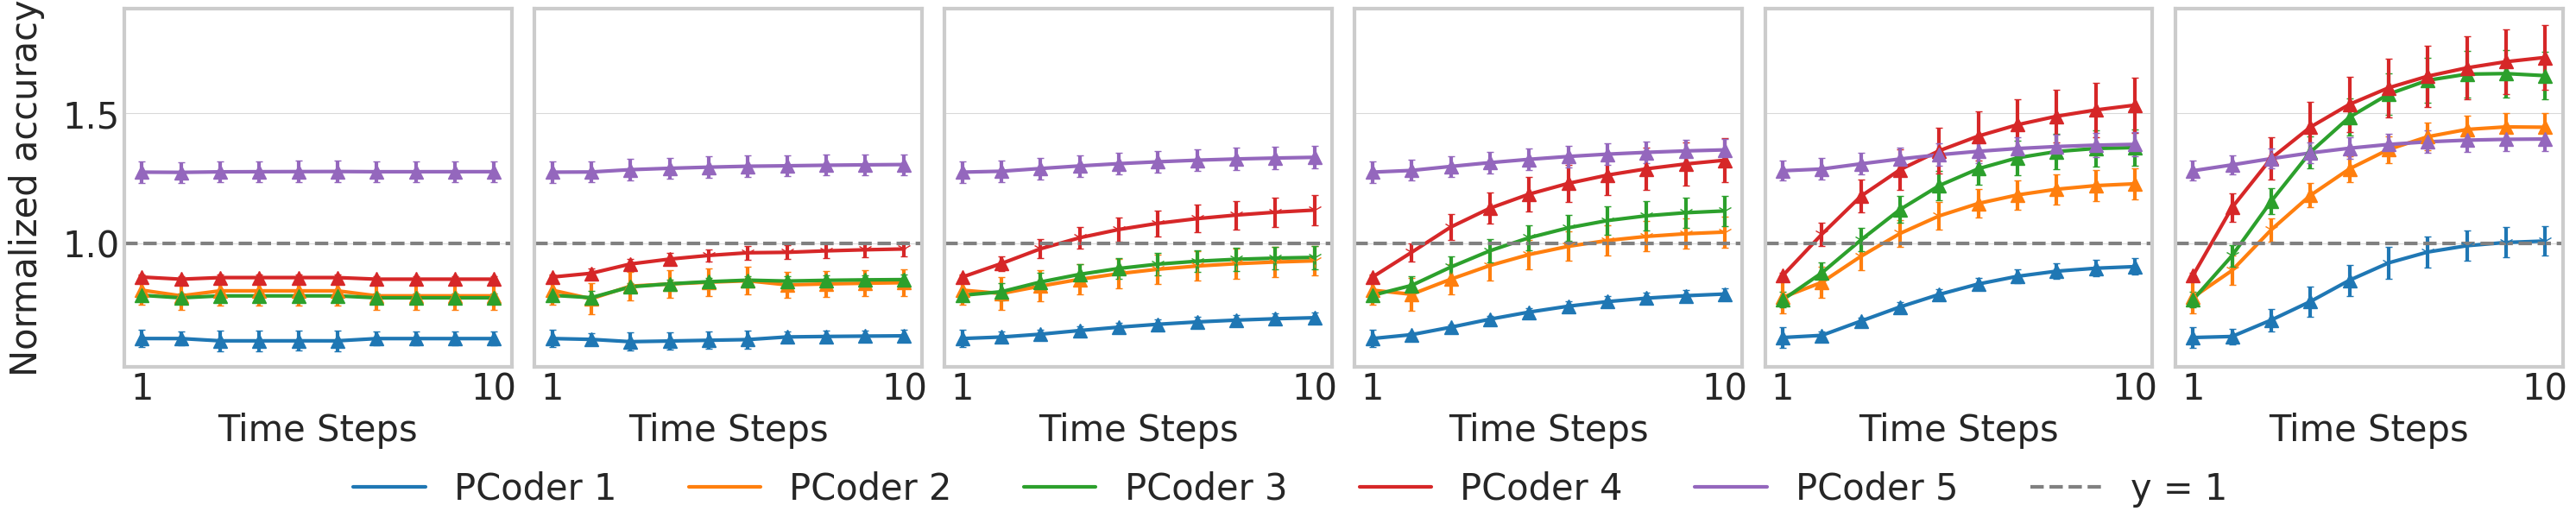

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib as mpl
from scipy import stats

# Set a fixed random seed for reproducibility
random.seed(5)

# Plot settings
fig = plt.figure()
fig.set_size_inches((8, 6))
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['lines.linewidth'] = 3 
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 30
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.3

# Define the time steps
time_steps = np.arange(1, 11)

# Set up the subplots
fig, axs = plt.subplots(1, 6, figsize=(30, 6), sharex=True, sharey=True)

# Assuming Avg_R_rd_high and SS_reversed_rd_high have the same shape
num_pcoders = Avg_R_rd_all['zero'].shape[1]
features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Compute min and max values for x and y ticks
x_min, x_max = time_steps.min(), time_steps.max()


# Positions to plot
plot_positions = [0, 1, 2, 3, 4, 5]

for i, pos in enumerate(plot_positions):
    # Plot the high complexity line with error bars

    for j in range(Avg_R_rd_all[keys[pos]].shape[1]):
        
        axs[pos].plot(time_steps,Avg_R_rd_all[keys[pos]][:, j],linestyle='-', label=f'PCoder {j+1}', color=f'C{j}')
        # Overlay points with distinct markers for significant and non-significant points
        for t in range(len(time_steps)):
            if Avg_P_all[keys[pos]][t][j] < 0.05:
                marker = '^'  # Triangle marker for significant points
                marker_color = f'C{j}'  # Use red for significant points
                marker_size = 12  # Increase size for emphasis
            else:
                marker = '1'  # Circle marker for non-significant points
                marker_color = f'C{j}'  # Use line color for non-significant points
                marker_size = 12  # Default size
            
            axs[pos].errorbar(
            time_steps[t],  # Single time step
            Avg_R_rd_all[keys[pos]][t, j],  # Corresponding y-value
            yerr=std_R_rd_all[keys[pos]][t, j],  # Corresponding error
            fmt=marker,  # Conditionally selected marker
            capsize=3,
            color=marker_color,  # Use marker-specific color
            markersize=marker_size  # Set marker size
            )
    
    
    axs[pos].axhline(y=1, color='grey', linestyle='--',label='y = 1')

    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)

    # Set limited x- and y-ticks
    #y_min = min(Avg_R_rd_all[keys[pos]].min(), Avg_R_rd_Low.min())
    #y_max = max(Avg_R_rd_high.max(), Avg_R_rd_Low.max())
    axs[pos].set_xticks([x_min, x_max])
    #axs[pos].set_yticks([y_min, y_max])
    axs[pos].set_xlabel('Time Steps')

# Common x-axis and y-axis labels
#axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Normalized accuracy', labelpad=15, loc='center') 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Add a shared legend below the figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.15))

# Save the plot
filename = 'Avg_roi_it_allkeys.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

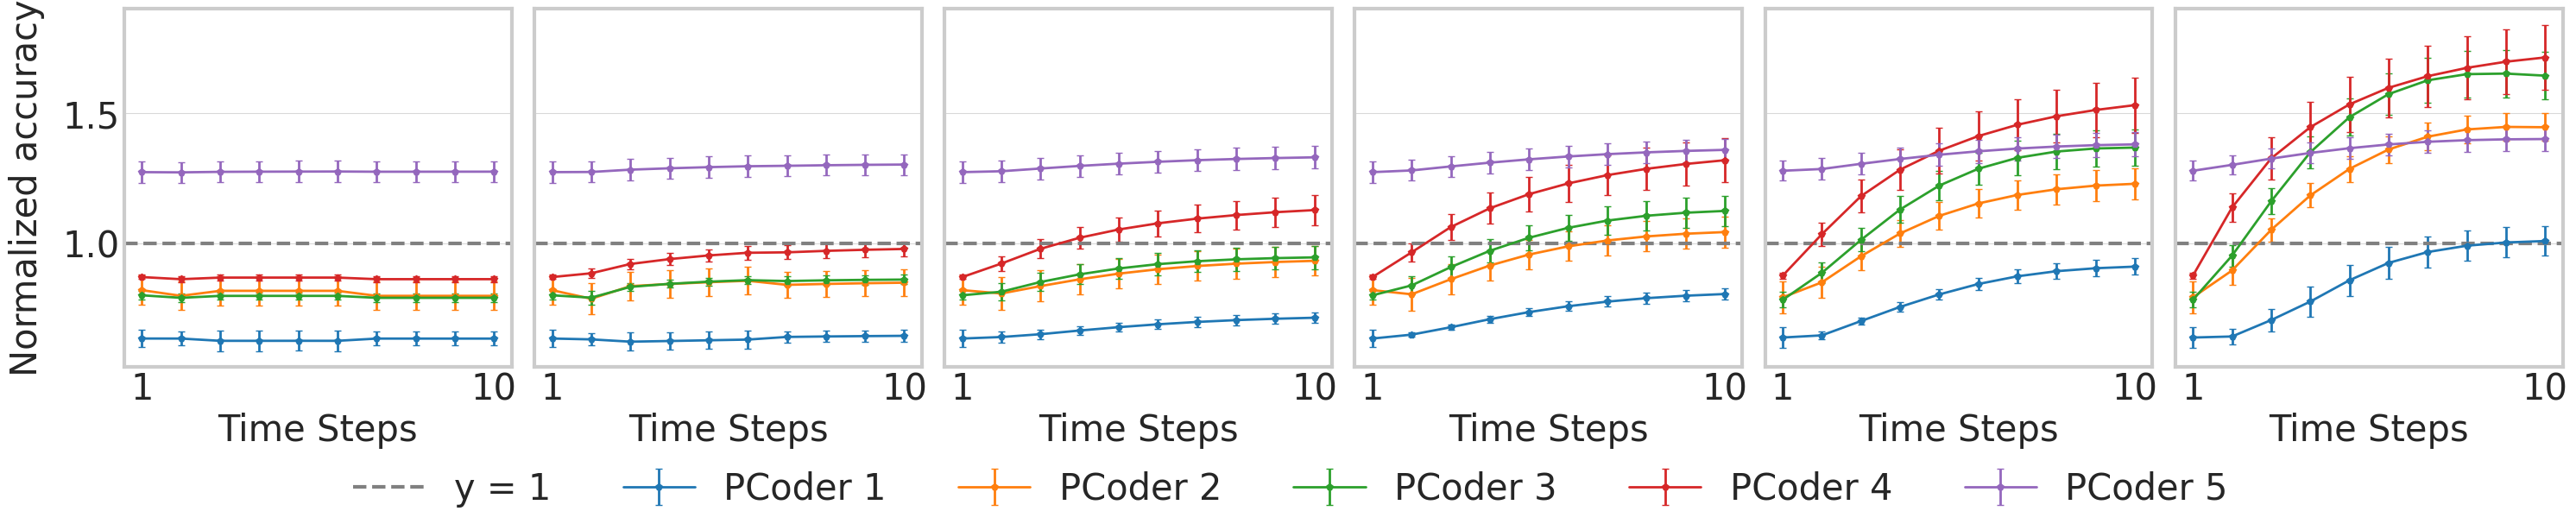

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib as mpl
from scipy import stats

# Set a fixed random seed for reproducibility
random.seed(5)

# Plot settings
fig = plt.figure()
fig.set_size_inches((8, 6))
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['lines.linewidth'] = 3 
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 30
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.3

# Define the time steps
time_steps = np.arange(1, 11)

# Set up the subplots
fig, axs = plt.subplots(1, 6, figsize=(30, 6), sharex=True, sharey=True)

# Assuming Avg_R_rd_high and SS_reversed_rd_high have the same shape
num_pcoders = Avg_R_rd_all['zero'].shape[1]
features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Compute min and max values for x and y ticks
x_min, x_max = time_steps.min(), time_steps.max()


# Positions to plot
plot_positions = [0, 1, 2, 3, 4,5]

for i, pos in enumerate(plot_positions):
    # Plot the high complexity line with error bars

    for i in range(Avg_R_rd_all[keys[pos]].shape[1]):
        axs[pos].errorbar(time_steps, Avg_R_rd_all[keys[pos]][:, i], yerr=std_R_rd_all[keys[pos]][:, i], label=f'PCoder {i+1}', linestyle='-', marker='p',capsize=3,linewidth=2)
    
    axs[pos].axhline(y=1, color='grey', linestyle='--',label='y = 1')

    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)

    # Set limited x- and y-ticks
    #y_min = min(Avg_R_rd_all[keys[pos]].min(), Avg_R_rd_Low.min())
    #y_max = max(Avg_R_rd_high.max(), Avg_R_rd_Low.max())
    axs[pos].set_xticks([x_min, x_max])
    #axs[pos].set_yticks([y_min, y_max])
    axs[pos].set_xlabel('Time Steps')

# Common x-axis and y-axis labels
#axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Normalized accuracy', labelpad=15, loc='center') 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Add a shared legend below the figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.15))

# Save the plot
filename = 'Avg_roi_it_allkeys.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [25]:
arch = args.arch
subject = [1,2,4,5,7]
#subject = [1,2,7]
ROI_Cat = ['prf-visualrois','floc-bodies','floc-faces','floc-places','floc-words']
k = 0 #rois
key = 'zero'

M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred = final_analysis(subject,key,ROI_Cat)
MM_reversed_rd,MM_reversed_pred,MM_reversed_nonpred,SS_reversed_rd,SS_reversed_pred,SS_reversed_nonpred=reverse_value(M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred)

1
Tutorial_LE_Results_Ridge_opt/subj1/ts1/vgg16.csv
Tutorial_LE_Results_Ridge_opt/subj1/vgg16_zero/ts1/vgg16.csv
[0.51456042 0.15445367 0.46208115 0.24256211 1.17693544 0.33432141
 0.740437   0.61308168 1.32498131 0.42532553 0.91985349 0.76584619
 1.39008505 0.69400077 1.21712107 1.01771969 1.36482798 1.08210293
 1.4456445  1.25217877] [0.05257965 0.02956442 0.12366624 0.03836048 0.17876913 0.09522415
 0.24878026 0.14767229 0.29756829 0.16101582 0.34528439 0.25539979
 0.40775005 0.26434651 0.41046927 0.36855561 0.35782039 0.29806032
 0.32538605 0.34268451] [0.10218363 0.19141285 0.26762884 0.15814705 0.15189375 0.28482814
 0.33599112 0.24086886 0.22458301 0.37857078 0.3753689  0.33348706
 0.29332742 0.38090233 0.33724605 0.36213862 0.26217252 0.27544544
 0.22508027 0.2736706 ]
Tutorial_LE_Results_Ridge_opt/subj2/ts1/vgg16.csv
Tutorial_LE_Results_Ridge_opt/subj2/vgg16_zero/ts1/vgg16.csv
[0.2000766  0.12890943 0.21174885 0.69051492 0.54969636 0.36523466
 0.59254435 1.36411616 0.73452169 

In [41]:
arch = args.arch
subject = [1,2,4,5,7]
#subject = [1,2,7]
ROI_Cat = ['prf-visualrois','floc-bodies','floc-faces','floc-places','floc-words']
k = 0 #rois
#key = 'zero'

keys = ['zero','one','two','three','four','five']
Avg_R_rd_all = {}
std_R_rd_all = {}
Avg_P_all = {}

for key in keys:
    M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred = final_analysis(subject,key,ROI_Cat,k)
    MM_reversed_rd,MM_reversed_pred,MM_reversed_nonpred,SS_reversed_rd,SS_reversed_pred,SS_reversed_nonpred=reverse_value(M_rd,M_pred,M_nonpred,ST_rd,ST_pred,ST_nonpred,Md_rd,Md_pred,Md_nonpred)
    P_alltimesteps = significance_difference(MM_reversed_rd,SS_reversed_rd)
    Avg_R_rd_all[key] = MM_reversed_rd
    std_R_rd_all[key] = SS_reversed_rd
    Avg_P_all[key] = P_alltimesteps

1
2
3
4
5
6
7
8
9
10
Significance results for PCoder 1:
Time 1.00: t-stat = -22.37, p-value = 0.0000
  Significant at p < 0.05
Time 2.00: t-stat = -30.29, p-value = 0.0000
  Significant at p < 0.05
Time 3.00: t-stat = -20.80, p-value = 0.0000
  Significant at p < 0.05
Time 4.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 5.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 6.00: t-stat = -20.79, p-value = 0.0000
  Significant at p < 0.05
Time 7.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 8.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 9.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Time 10.00: t-stat = -30.26, p-value = 0.0000
  Significant at p < 0.05
Significance results for PCoder 2:
Time 1.00: t-stat = -8.11, p-value = 0.0000
  Significant at p < 0.05
Time 2.00: t-stat = -11.75, p-value = 0.0000
  Significant at p < 0.05
Time 3.00: t-stat = -7.39, p-value = 0.0000
  Significant

<Figure size 800x600 with 0 Axes>

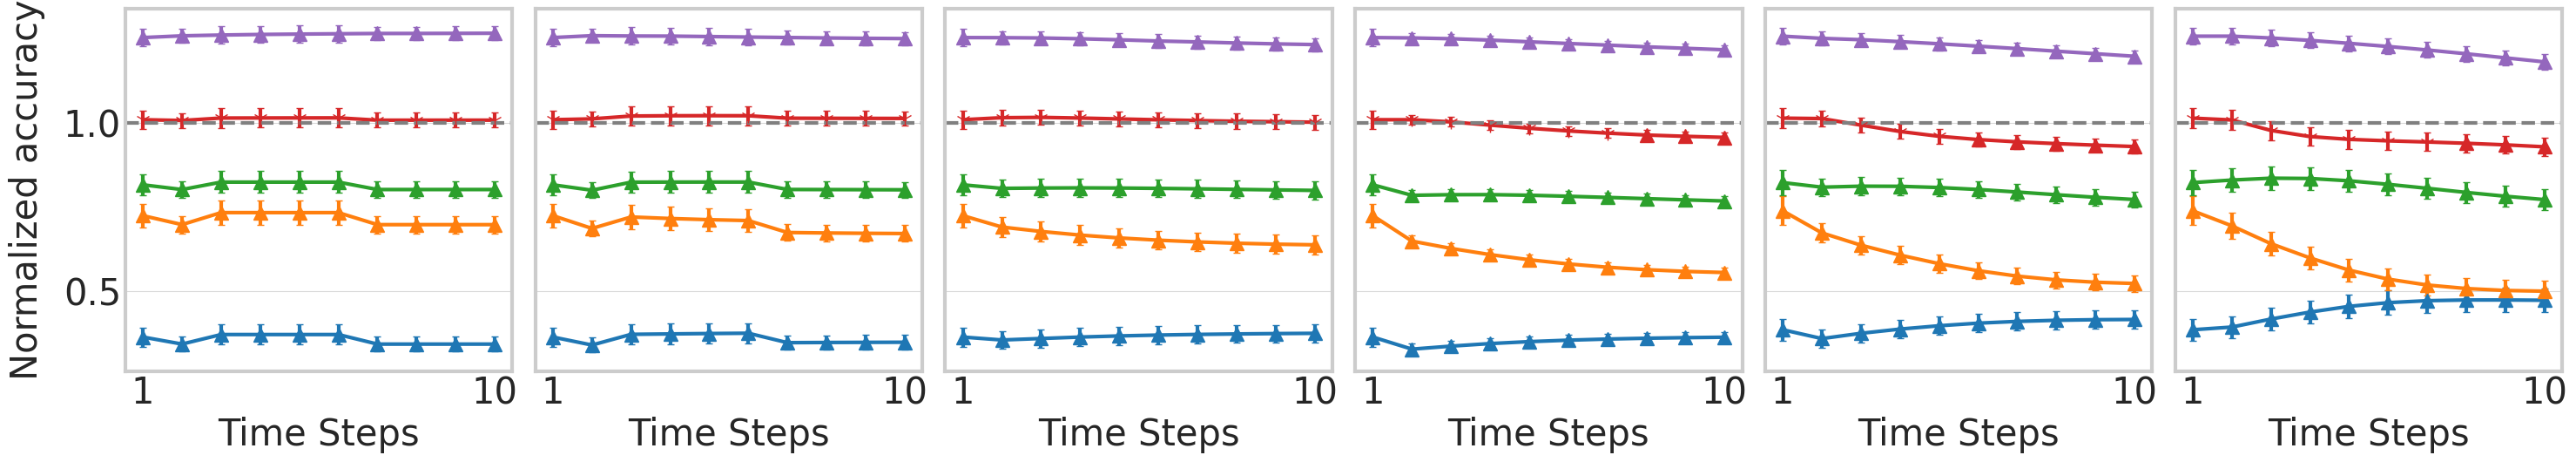

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib as mpl
from scipy import stats

# Set a fixed random seed for reproducibility
random.seed(5)

# Plot settings
fig = plt.figure()
fig.set_size_inches((8, 6))
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 30
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.3

# Define the time steps
time_steps = np.arange(1, 11)

# Set up the subplots
fig, axs = plt.subplots(1, 6, figsize=(30, 6), sharex=True, sharey=True)

# Assuming Avg_R_rd_high and SS_reversed_rd_high have the same shape
num_pcoders = Avg_R_rd_all['zero'].shape[1]
features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Compute min and max values for x and y ticks
x_min, x_max = time_steps.min(), time_steps.max()

# Positions to plot
plot_positions = [0, 1, 2, 3, 4, 5]

for i, pos in enumerate(plot_positions):
    # Plot the high complexity line with error bars

    for j in range(Avg_R_rd_all[keys[pos]].shape[1]):
        
        axs[pos].plot(time_steps,Avg_R_rd_all[keys[pos]][:, j],linestyle='-', label=f'PCoder {j+1}', color=f'C{j}')
        # Overlay points with distinct markers for significant and non-significant points
        for t in range(len(time_steps)):
            if Avg_P_all[keys[pos]][t][j] < 0.05:
                marker = '^'  # Triangle marker for significant points
                marker_color = f'C{j}'  # Use red for significant points
                marker_size = 12  # Increase size for emphasis
            else:
                marker = '1'  # Circle marker for non-significant points
                marker_color = f'C{j}'  # Use line color for non-significant points
                marker_size = 12  # Default size
            
            axs[pos].errorbar(
            time_steps[t],  # Single time step
            Avg_R_rd_all[keys[pos]][t, j],  # Corresponding y-value
            yerr=std_R_rd_all[keys[pos]][t, j],  # Corresponding error
            fmt=marker,  # Conditionally selected marker
            capsize=3,
            color=marker_color,  # Use marker-specific color
            markersize=marker_size  # Set marker size
            )
    
    axs[pos].axhline(y=1, color='grey', linestyle='--', label='y = 1')

    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)

    # Set limited x- and y-ticks
    #y_min, y_max = Avg_R_rd_all[keys[pos]].min(), Avg_R_rd_all[keys[pos]].max()
    axs[pos].set_xticks([x_min, x_max])
    #axs[pos].set_yticks([y_min, y_max])  # Only two y-ticks
    axs[pos].set_xlabel('Time Steps')

# Common x-axis and y-axis labels
#axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Normalized accuracy', labelpad=15, loc='center') 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Add a shared legend below the figure
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.1))

# Save the plot
filename = 'Avg_roi_prf_allkeys.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

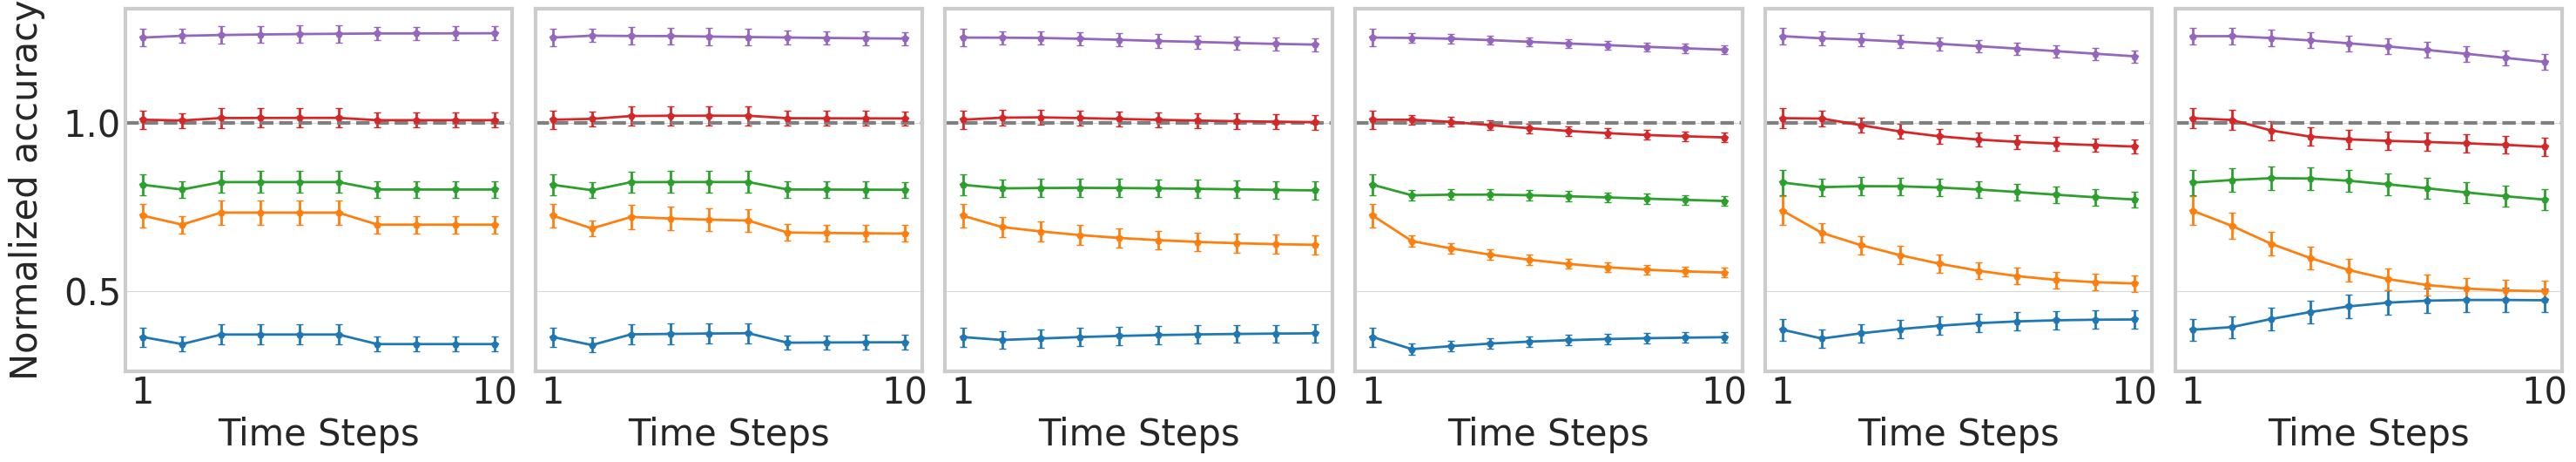

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib as mpl
from scipy import stats

# Set a fixed random seed for reproducibility
random.seed(5)

# Plot settings
fig = plt.figure()
fig.set_size_inches((8, 6))
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 30
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.3

# Define the time steps
time_steps = np.arange(1, 11)

# Set up the subplots
fig, axs = plt.subplots(1, 6, figsize=(30, 6), sharex=True, sharey=True)

# Assuming Avg_R_rd_high and SS_reversed_rd_high have the same shape
num_pcoders = Avg_R_rd_all['zero'].shape[1]
features_map = ['features.3', 'features.8', 'features.15', 'features.22', 'features.29']

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Compute min and max values for x and y ticks
x_min, x_max = time_steps.min(), time_steps.max()

# Positions to plot
plot_positions = [0, 1, 2, 3, 4, 5]

for i, pos in enumerate(plot_positions):
    # Plot the high complexity line with error bars
    for j in range(Avg_R_rd_all[keys[pos]].shape[1]):
        axs[pos].errorbar(time_steps, Avg_R_rd_all[keys[pos]][:, j], yerr=std_R_rd_all[keys[pos]][:, j], 
                          label=f'PCoder {j+1}', linestyle='-', marker='p', capsize=3, linewidth=2)
    
    axs[pos].axhline(y=1, color='grey', linestyle='--', label='y = 1')

    # Disable vertical grid lines
    axs[pos].xaxis.grid(False)

    # Set limited x- and y-ticks
    #y_min, y_max = Avg_R_rd_all[keys[pos]].min(), Avg_R_rd_all[keys[pos]].max()
    axs[pos].set_xticks([x_min, x_max])
    #axs[pos].set_yticks([y_min, y_max])  # Only two y-ticks
    axs[pos].set_xlabel('Time Steps')

# Common x-axis and y-axis labels
#axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Normalized accuracy', labelpad=15, loc='center') 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Add a shared legend below the figure
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.1))

# Save the plot
filename = 'Avg_roi_prf_allkeys.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
